In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Equalização

Neste notebook iremos explorar os próximos blocos na cadeia de algoritmos DSP que são dois equalizadores lineares que compensam os efeitos da dispersão cromática (CD) e da dispersão do modo de polarização (PMD) que são implementados na maioria dos receptores ópticos digitais coerentes.

Em sistemas ópticos digitais coerentes, a compensação CD é completamente deixada para o domínio digital. As vantagens dessa escolha são diversas, como a redução das perdas de inserção causadas pelos módulos ópticos de compensação de CD e a facilitação do projeto e gerenciamento do sistema. 

#### Equalização estática - Compensação CD:

Nos receptores ópticos digitais coerentes, o CD é compensado por filtros estáticos aplicados separadamente aos sinais das duas orientações de polarização. Como CD é praticamente invariante no tempo e independente da polarização, os filtros correspondentes às duas orientações de polarização possuem os mesmos coeficientes.

#### Equalização adaptativa - Compensação PMD:

Ao contrário da abordagem estática usada para compensação CD, a compensação PMD requer equalizadores que sejam capazes de atualizar adaptativamente seus coeficientes para rastrear variações na resposta de frequência do canal, causadas por perturbações mecânicas na geometria da fibra ou oscilações de temperatura. Além disso, como os canais de polarização se acoplam durante a transmissão por fibra, são necessárias arquiteturas com múltiplas entradas e múltiplas saídas (MIMO). Como benefício colateral, a equalização adaptativa também compensa efeitos lineares residuais, como o CD que sobrou do equalizador estático ou filtragem de banda estreita em interruptores seletivos de comprimento de onda.

### 5.1 Static Equalization

O módulo de compensação CD é o primeiro a ser implementado no receptor após o front-end e a compensação de suas imperfeições. Como o CD se comporta bem no tempo e afeta igualmente ambas as orientações de polarização, os filtros de compensação CD são estáticos, ou seja, seus coeficientes não variam com o tempo. As questões mais relevantes da compensação CD estão relacionadas com a implementação do hardware e a sua complexidade e consumo de energia.

A primeira tarefa para implementar filtros de compensação CD é dimensionar seus parâmetros levando em consideração as propriedades do canal óptico. Naturalmente, o design do equalizador está diretamente relacionado à propagação do atraso do canal. Uma aproximação para o *delay spread* do CD é dada por: 

$$\Delta T=|D|L\Delta\lambda=2\pi|\beta_{2}|L\Delta_{f}$$

onde $D$ é o parâmetro de dispersão da velocidade de grupo (GVD), $L$ é o comprimento da fibra, $\Delta \lambda$ e $\Delta f$ são as larguras de banda espectrais em comprimento de onda e frequência, e $\beta_{2}$ é a segunda derivada da constante de propagação $\beta$ em relação à frequência angular $\omega$. Se o sinal recebido for amostrado a uma taxa de amostragem $T_{Sa}$ (período de amostragem), o *delay spread* no número de amostras é dado por:

$$N_{\mathrm{DS}}=\left[\frac{\Delta T}{T_{S a}}\right]=\left[\frac{2\pi\,|\beta_{2}|L\,\Delta f}{T_{S a}}\,\right]$$

Assumindo modelagem de pulso de Nyquist com largura de banda mínima ($\Delta f\,\approx\,R_{s}$) e uma taxa de sobreamostragem $M/K\ (T_{S a}=K/(M R_{S}))$, então:

$$N_{\mathrm{DS}}\approx\left[2\pi|\beta_{2}|L R_{s}^{2}(M/K)\right]$$

Esperamos que o comprimento mínimo do equalizador CD seja proporcional ao $N_{DS}$, mas o valor exato depende de muitos aspectos, particularmente da forma do pulso e do filtro anti-aliasing. Uma expressão empírica para esse comprimento mínimo, validada para diversos formatos de pulso, é apresentado como:

$$N_{\mathrm{CD}}\approx\left[6.67|\beta_{2}|L R_{s}^{2}(M/K)\right]$$

### 5.1.1 Equalização no domínio da frequência

A depender das características do link o equalizador CD pode ter centenas ou milhares de *taps*, dependendo do taxa de amostragem e comprimento do link. Portanto, a equalização no domínio da frequência é geralmente preferida para reduzir a complexidade. Assumindo uma frequência de Nyquist $f_{N}\,=\,1/(2T_{S a})$, os coeficientes de um equalizador CD no domínio da frequência de tamanho NFFT são facilmente obtidos a partir da resposta de frequência CD dada por:

$$H_{\mathrm{CD}}[n]=e^{-j\frac{\pi\lambda^{2}D L}{c}\Big(n\frac{2f_{N}}{N_{\mathrm{FFT}}}\Big)^{2}},\ \ \ -\frac{N_{\mathrm{FFT}}}{2}\le n\le\ \frac{N_{\mathrm{FFT}}}{2}-1$$

Como esperado, o diagrama de amplitude é constante, indicando um filtro passa-tudo, enquanto o diagrama de fases mostra um perfil parabólico.Quanto maior for a dispersão acumulada, mais íngreme será o perfil parabólico.

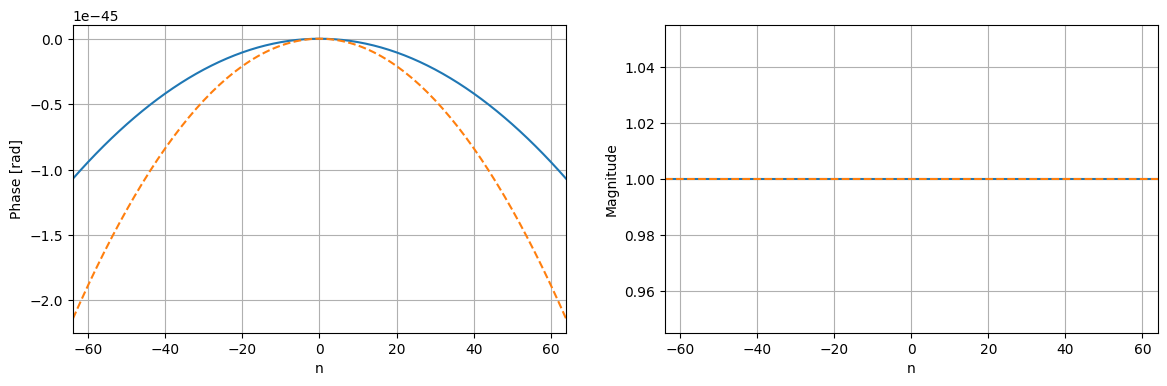

In [175]:
def frequency_responseHCD(n, Rs, D, NFFT, L, oversampling=1):
    λ = 1550e-9       # Comprimento de onda
    c = 299792458     # Velocidade da luz [m/s](vacuum)
    Tsa = 0.5*1/Rs
    fn = 1/2*Tsa
    return np.exp(-1j*np.pi*λ**2*D*L/c*(n*2*fn/NFFT)**2)

# parâmetros 
NFFT = 128      # compimento do filtro
Rs   = 50e9     # taxa de símbolos
D    = 17e-6    # parâmetro de dispersão ps/(nm*km)
n = np.arange(-NFFT/2, (NFFT/2)+1)

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].plot(n, np.angle(frequency_responseHCD(n, Rs, D, NFFT, L=100, oversampling=1)))
axs[0].plot(n, np.angle(frequency_responseHCD(n, Rs, D, NFFT, L=200, oversampling=1)), '--')
axs[0].set_xlim(-NFFT/2, NFFT/2)
axs[0].set_ylabel('Phase [rad]')
axs[0].set_xlabel('n')
axs[0].grid()

axs[1].plot(n,  np.abs(frequency_responseHCD(n, Rs, D, NFFT, L=100, oversampling=1)))
axs[1].plot(n,  np.abs(frequency_responseHCD(n, Rs, D, NFFT, L=200, oversampling=1)), '--')
axs[1].set_xlim(-NFFT/2, NFFT/2)
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('n')
axs[1].grid()